In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#Initial CSV Read

xGS_Total = pd.read_csv(r'..\CSVs\International\Int_xGS_Total.csv' ,encoding='latin-1')
xGA_Total = pd.read_csv(r'..\CSVs\International\Int_xGA_Total.csv' ,encoding='latin-1')
# loading linear algorithms
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge

# tree based algorithms
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# machine learning processing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
# Get corrs between Gls and features
xGS_corrs = abs(xGS_Total.corr())['Gls'].sort_values(ascending=False)
xGA_corrs = abs(xGA_Total.corr())['O. Gls'].sort_values(ascending=False)

In [4]:
# It looks like G/Sh is the highest correlated feature with Gls.
xGS_corrs

Gls        1.000000
G/Sh       0.812597
SoT        0.779099
G/SoT      0.687219
Sh         0.599977
Poss       0.576907
SoT%       0.506920
PKatt      0.310739
MP         0.285975
O. CrdY    0.267001
CrdY       0.264677
Int        0.217464
Year       0.166428
CrdR       0.133139
Fld        0.121539
TklW       0.062697
O. TklW    0.062034
Age        0.048508
Name: Gls, dtype: float64

In [ ]:
xGA_corrs

In [ ]:
xGS_Total.columns

In [5]:
# first ML model for XGS & xGA, dropping irrelevant features AND FEATURES THAT ARE VERY SIMILAR 
xGS_Column_Drop_List = ['Key','Year','Competition','Squad','Age','Sh','MP','G/SoT','CrdY','CrdR','Fld','TklW','O. TklW','G/Sh']
xGA_Column_Drop_List = ['Key','Year','Competition','Squad','O. Age','O. Sh','O. MP','O. G/SoT','O. CrdR','O. Fld', 'O. TklW', 'TklW','O. G/Sh']

xGS_Model_1 = xGS_Total.drop(xGS_Column_Drop_List, axis=1)
xGA_Model_1 = xGA_Total.drop(xGA_Column_Drop_List, axis=1)

In [ ]:
# Scaling Remaining Features - removing Gls and Confederation when scaling, and adding back in

xGS_Model_1_features = xGS_Model_1.drop(['Confederation','Gls'], axis=1)
xGA_Model_1_features = xGA_Model_1.drop(['Confederation','O. Gls'], axis=1)

xGS_scaler = StandardScaler().fit(xGS_Model_1_features)
xGA_scaler = StandardScaler().fit(xGA_Model_1_features)


xGS_scaler_df = pd.DataFrame(xGS_scaler.transform(xGS_Model_1_features), columns = xGS_Model_1_features.columns)
xGA_scaler_df = pd.DataFrame(xGA_scaler.transform(xGA_Model_1_features), columns = xGA_Model_1_features.columns)

xGS_scaler_df['Gls'] = xGS_Model_1['Gls']
xGA_scaler_df['O. Gls'] = xGA_Model_1['O. Gls']
xGS_scaler_df['Confederation'] = xGS_Model_1['Confederation']
xGA_scaler_df['Confederation'] = xGA_Model_1['Confederation']

In [ ]:
# Create final model variable and one-hot encode Confederation

xGS_Model_1_Final = pd.get_dummies(xGS_scaler_df, columns=['Confederation'])
xGA_Model_1_Final = pd.get_dummies(xGA_scaler_df, columns=['Confederation'])

In [ ]:
xGS_Model_1_Final

In [ ]:
# Get features and target for both models

xGS_X = xGS_Model_1_Final.drop('Gls', axis=1).values
xGS_y = xGS_Model_1_Final['Gls'].values

xGA_X = xGA_Model_1_Final.drop('O. Gls', axis=1).values
xGA_y = xGA_Model_1_Final['O. Gls']

In [ ]:
# Use the Sklearn `train_test_split()` function to split the data into training and testing data
xGS_X_train, xGS_X_test, xGS_y_train, xGS_y_test = train_test_split(xGS_X, xGS_y, random_state=42, test_size=.15)

# Use the Sklearn `train_test_split()` function to split the data into training and testing data
xGA_X_train, xGA_X_test, xGA_y_train, xGA_y_test = train_test_split(xGA_X, xGA_y, random_state=42, test_size=.15)

In [6]:
# Evaluate Model function

def evaluateModel(model, X_train, y_train, X_test, y_test):
    # FIT THE MODEL
    model.fit(X_train, y_train)

    # EVALUATE the MODEL
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # PRINT the METRICS
    print("TRAINING SET")

    # Score the prediction with MSE and R2
    mse_train = np.sqrt(mean_squared_error(y_train, train_preds))
    r2_train = r2_score(y_train, train_preds)
    mae_train = mean_absolute_error(y_train, train_preds)

    print(f"root mean squared error (RMSE): {mse_train}")
    print(f"R-squared (R2 ): {r2_train}")
    print(f"MAE {mae_train}")

    print()

    # PRINT the METRICS
    print("Testing SET")

    # Score the prediction with MSE and R2
    mse_test = np.sqrt(mean_squared_error(y_test, test_preds))
    r2_test = r2_score(y_test, test_preds)
    mae_test = mean_absolute_error(y_test, test_preds)

    print(f"root mean squared error (RMSE): {mse_test}")
    print(f"R-squared (R2 ): {r2_test}")
    print(f"MAE {mae_test}")
    
    plt.figure(figsize=(10,6))
    plt.scatter(y_test, test_preds)
    plt.title("Actual vs Predicted Plot")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.plot(y_test, y_test)
    plt.show()
    
    # Plot Residuals
    plt.figure(figsize=(10,6))
    plt.scatter(test_preds, test_preds - y_test)
    plt.hlines(y=0, xmin=test_preds.min(), xmax=test_preds.max(), color="r")
    plt.title("Residuals")
    plt.xlabel("Prediction")
    plt.ylabel("Error")
    plt.show()

    return(model)

In [ ]:
# xGS Model EXPLORATION:

In [ ]:
lr = LinearRegression()
lr = evaluateModel(lr, xGS_X_train, xGS_y_train, xGS_X_test, xGS_y_test)

In [ ]:
ridge = Ridge()
ridge = evaluateModel(ridge, xGS_X_train, xGS_y_train, xGS_X_test, xGS_y_test)

In [ ]:
# Elastic net, DecisionTreeRegressor, 

In [ ]:
rf = RandomForestRegressor()
rf = evaluateModel(rf, xGS_X_train, xGS_y_train, xGS_X_test, xGS_y_test)

In [ ]:
ada = AdaBoostRegressor(random_state=42)
ada = evaluateModel(ada, xGS_X_train, xGS_y_train, xGS_X_test, xGS_y_test)

In [ ]:
gb = GradientBoostingRegressor(random_state=42)
gb = evaluateModel(gb, xGS_X_train, xGS_y_train, xGS_X_test, xGS_y_test)

In [ ]:
xgb = XGBRegressor(random_state=42)
xgb = evaluateModel(xgb, xGS_X_train, xGS_y_train, xGS_X_test, xGS_y_test)

In [ ]:
lgbm = LGBMRegressor(random_state=42)
lgbm = evaluateModel(lgbm, xGS_X_train, xGS_y_train, xGS_X_test, xGS_y_test)

In [ ]:
gb = GradientBoostingRegressor(random_state=42)
gb = evaluateModel(gb, xGA_X_train, xGA_y_train, xGA_X_test, xGA_y_test)

In [ ]:
lr = LinearRegression()
lr = evaluateModel(lr, xGA_X_train, xGA_y_train, xGA_X_test, xGA_y_test)

In [ ]:
xGS_Total.columns

In [ ]:
xGA_Total.columns

In [7]:
# Second Model Attempt - Keeping similar metrics in to see if predictive abilities increase

 
xGS_Column_Drop_List2 = ['Key','Year','Competition','Squad','Age','MP','G/SoT','TklW','O. TklW','G/Sh']
xGA_Column_Drop_List2 = ['Key','Year','Competition','Squad','O. Age','O. MP','O. G/SoT','O. Fld', 'O. TklW', 'TklW','O. G/Sh']

xGS_Model_2 = xGS_Total.drop(xGS_Column_Drop_List2, axis=1)
xGA_Model_2 = xGA_Total.drop(xGA_Column_Drop_List2, axis=1)

In [8]:
xGS_Model_2

,Poss,Gls,Sh,SoT,SoT%,PKatt,CrdY,CrdR,Fld,Int,Confederation,O. CrdY
0,66.0,1.13,16.8,5.85,34.8,0.00,0.75,0.0,10.20,9.81,AFC,1.32
1,51.7,0.67,10.7,2.33,21.9,0.67,2.33,0.0,11.00,8.00,AFC,1.67
2,46.3,0.70,15.6,4.19,26.9,0.23,0.47,0.0,12.60,10.00,AFC,1.40
3,50.6,1.20,9.6,3.20,33.3,0.20,1.00,0.0,11.80,10.40,AFC,1.40
4,36.7,1.33,9.0,3.00,33.3,0.33,0.67,0.0,11.00,13.00,AFC,1.33
...,...,...,...,...,...,...,...,...,...,...,...,...
381,52.4,1.42,10.0,3.81,38.1,0.27,0.44,0.0,8.05,7.26,UEFA,2.30
382,24.9,0.10,3.8,0.90,23.7,0.00,2.40,0.1,10.70,11.40,UEFA,0.90
383,22.0,0.10,2.4,1.10,45.8,0.00,1.80,0.0,10.10,8.20,UEFA,0.80
384,49.7,1.30,11.1,3.70,33.3,0.20,2.10,0.1,13.70,9.40,UEFA,2.20


In [ ]:
xGA_corrs

In [ ]:
xGA_Model_2

In [9]:
# Don't Scale
xGS_Model_2_features = xGS_Model_2.drop(['Confederation','Gls'], axis=1)
xGA_Model_2_features = xGA_Model_2.drop(['Confederation','O. Gls'], axis=1)

#xGS_scaler2 = StandardScaler().fit(xGS_Model_2_features)
#xGA_scaler2 = StandardScaler().fit(xGA_Model_2_features)


#xGS_scaler_df2 = pd.DataFrame(xGS_scaler2.transform(xGS_Model_2_features), columns = xGS_Model_2_features.columns)
#xGA_scaler_df2 = pd.DataFrame(xGA_scaler2.transform(xGA_Model_2_features), columns = xGA_Model_2_features.columns)

xGS_scaler_df2['Gls'] = xGS_Model_2['Gls']
xGA_scaler_df2['O. Gls'] = xGA_Model_2['O. Gls']
xGS_scaler_df2['Confederation'] = xGS_Model_2['Confederation']
xGA_scaler_df2['Confederation'] = xGA_Model_2['Confederation']

NameError: name 'xGS_scaler_df2' is not defined

In [10]:
# Create final model variable and one-hot encode Confederation

xGS_Model_2_Final = pd.get_dummies(xGS_Model_2, columns=['Confederation'])
xGA_Model_2_Final = pd.get_dummies(xGA_Model_2, columns=['Confederation'])

In [11]:
# Get features and target for both models

xGS_X2 = xGS_Model_2_Final.drop('Gls', axis=1).values
xGS_y2 = xGS_Model_2_Final['Gls'].values

xGA_X2 = xGA_Model_2_Final.drop('O. Gls', axis=1).values
xGA_y2 = xGA_Model_2_Final['O. Gls']

In [12]:
# Use the Sklearn `train_test_split()` function to split the data into training and testing data
xGS_X_train2, xGS_X_test2, xGS_y_train2, xGS_y_test2 = train_test_split(xGS_X2, xGS_y2, random_state=42, test_size=.2)

# Use the Sklearn `train_test_split()` function to split the data into training and testing data
xGA_X_train2, xGA_X_test2, xGA_y_train2, xGA_y_test2 = train_test_split(xGA_X2, xGA_y2, random_state=42, test_size=.2)

TRAINING SET
root mean squared error (RMSE): 0.370847534725316
R-squared (R2 ): 0.6969068959668192
MAE 0.2916423641738684

Testing SET
root mean squared error (RMSE): 0.42832817159583664
R-squared (R2 ): 0.6353817448448691
MAE 0.3366434580953806


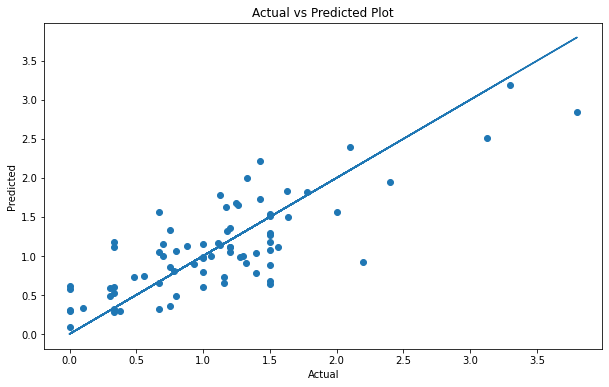

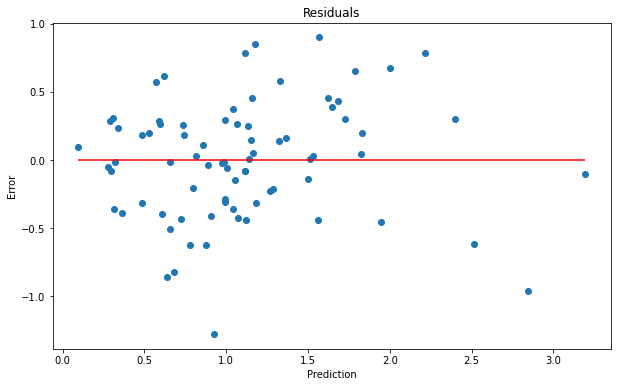

In [13]:
lr = LinearRegression()
lr = evaluateModel(lr, xGS_X_train2, xGS_y_train2, xGS_X_test2, xGS_y_test2)

TRAINING SET
root mean squared error (RMSE): 0.4713259521274882
R-squared (R2 ): 0.5104151504906009
MAE 0.356319251132854

Testing SET
root mean squared error (RMSE): 0.5028960065571234
R-squared (R2 ): 0.49737798873848005
MAE 0.38805661439347955


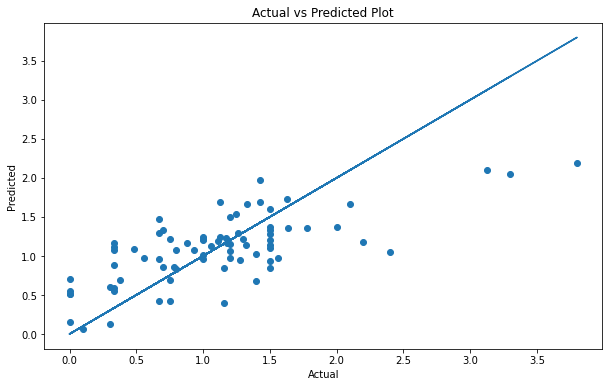

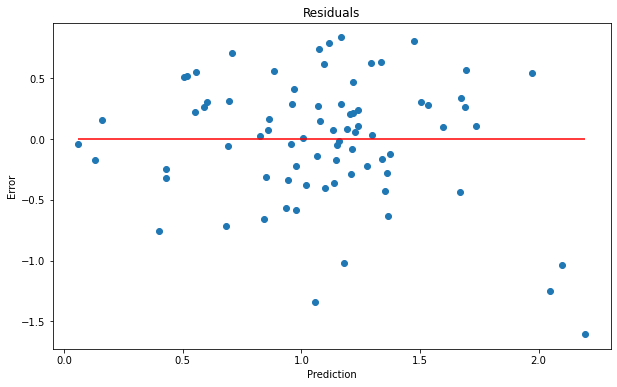

In [14]:
en = ElasticNet()
en = evaluateModel(en,xGS_X_train2, xGS_y_train2, xGS_X_test2, xGS_y_test2)

TRAINING SET
root mean squared error (RMSE): 0.06918670458894682
R-squared (R2 ): 0.9894505321363481
MAE 0.050793508695923265

Testing SET
root mean squared error (RMSE): 0.423089257993282
R-squared (R2 ): 0.6442465440435978
MAE 0.33080828420964775


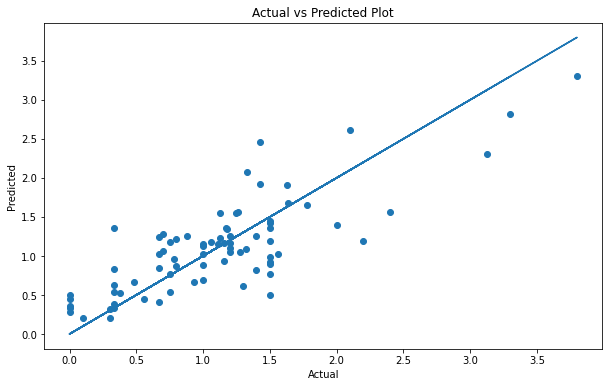

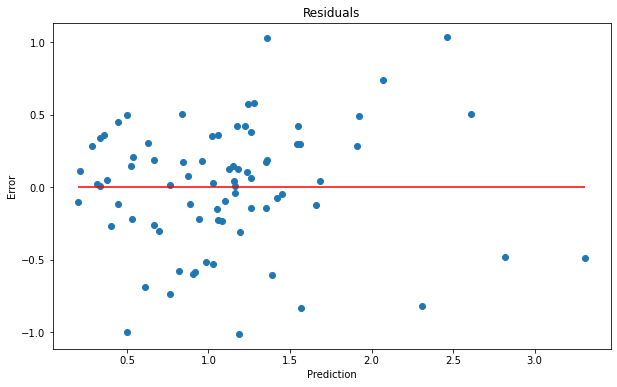

In [15]:
gb = GradientBoostingRegressor(random_state=42, n_estimators=600, learning_rate=.05)
gb = evaluateModel(gb, xGS_X_train2, xGS_y_train2, xGS_X_test2, xGS_y_test2)

TRAINING SET
root mean squared error (RMSE): 0.1565351982505816
R-squared (R2 ): 0.9459980704369463
MAE 0.11872732998823911

Testing SET
root mean squared error (RMSE): 0.4719078567457153
R-squared (R2 ): 0.5574120906814273
MAE 0.36433190607241156


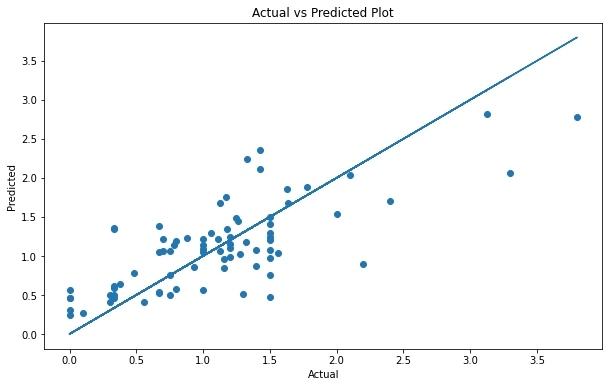

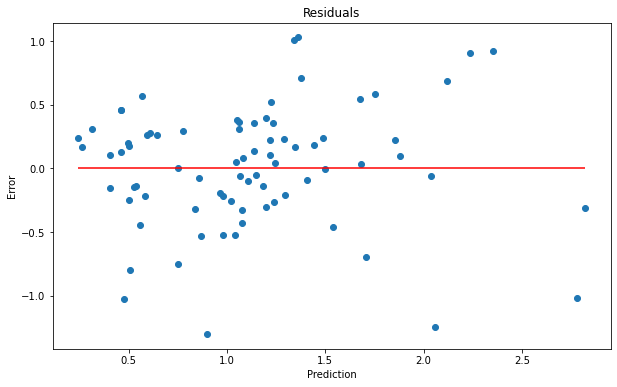

In [16]:
lgbm = LGBMRegressor(random_state=42)
lgbm = evaluateModel(lgbm, xGS_X_train2, xGS_y_train2, xGS_X_test2, xGS_y_test2)

TRAINING SET
root mean squared error (RMSE): 0.0009198986378408976
R-squared (R2 ): 0.9999981350584954
MAE 0.000631461735211611

Testing SET
root mean squared error (RMSE): 0.5115600367632016
R-squared (R2 ): 0.4799101842973388
MAE 0.3786569235722224


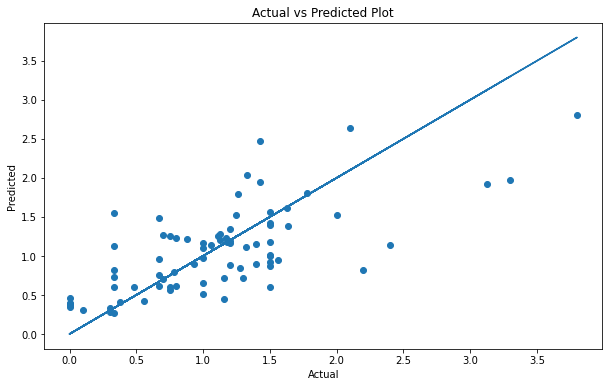

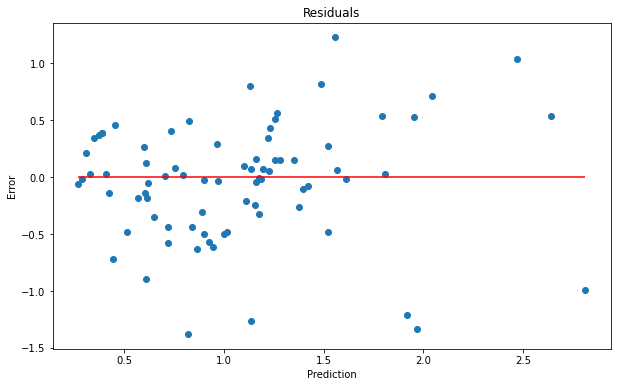

In [17]:
xgb = XGBRegressor(random_state=42)
xgb = evaluateModel(xgb, xGS_X_train2, xGS_y_train2, xGS_X_test2, xGS_y_test2)

TRAINING SET
root mean squared error (RMSE): 0.37110519736369624
R-squared (R2 ): 0.6964855751177899
MAE 0.29099107835562105

Testing SET
root mean squared error (RMSE): 0.4270402318120735
R-squared (R2 ): 0.6375711890991834
MAE 0.3351207088247265


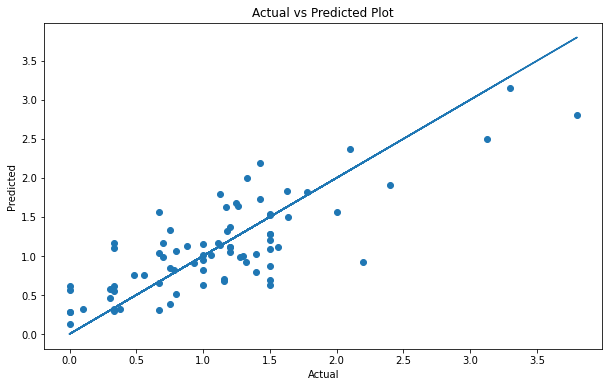

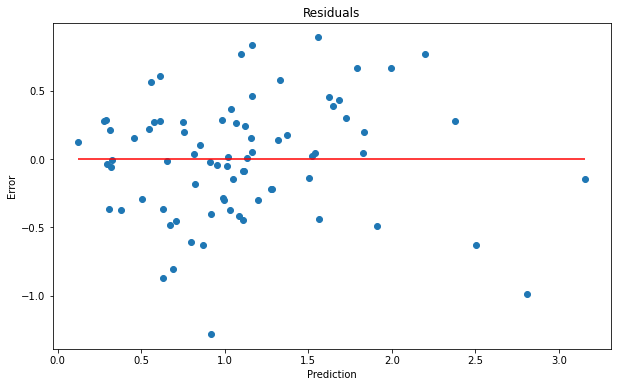

In [18]:
ridge = Ridge()
ridge = evaluateModel(ridge, xGS_X_train2, xGS_y_train2, xGS_X_test2, xGS_y_test2)

TRAINING SET
root mean squared error (RMSE): 0.32513508923210344
R-squared (R2 ): 0.7670230546723592
MAE 0.2683693627554584

Testing SET
root mean squared error (RMSE): 0.45526637317457336
R-squared (R2 ): 0.5880767767275034
MAE 0.35957572475901894


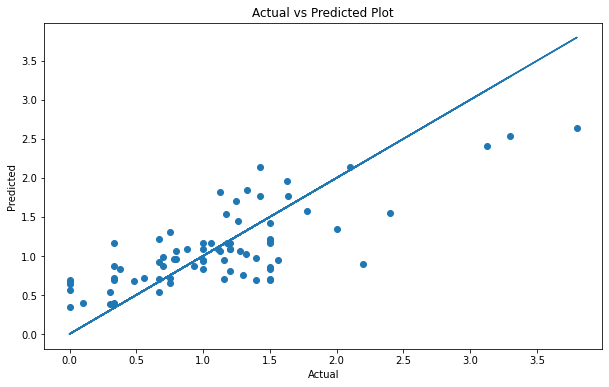

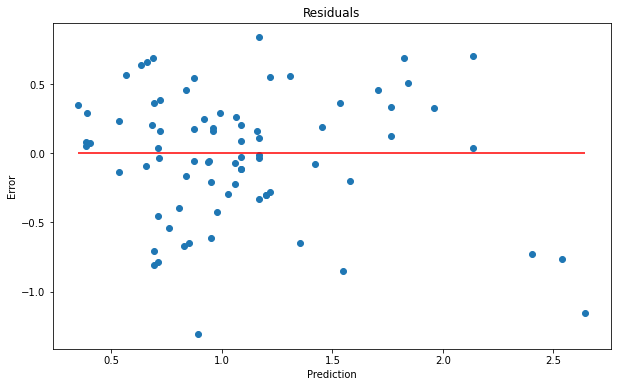

In [19]:
ada = AdaBoostRegressor(random_state=42)
ada = evaluateModel(ada, xGS_X_train2, xGS_y_train2, xGS_X_test2, xGS_y_test2)

TRAINING SET
root mean squared error (RMSE): 0.14771347374114288
R-squared (R2 ): 0.9519132433608316
MAE 0.11011688311688306

Testing SET
root mean squared error (RMSE): 0.454332263482383
R-squared (R2 ): 0.5897654001493231
MAE 0.3513358974358973


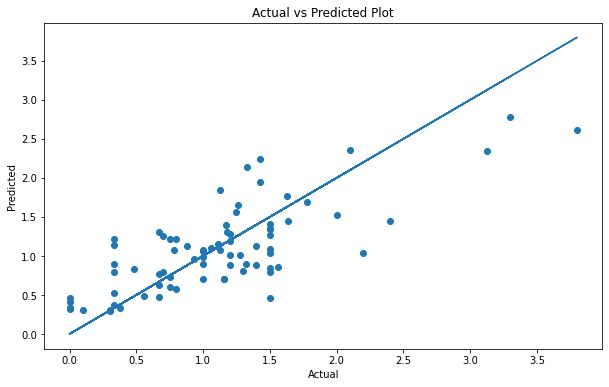

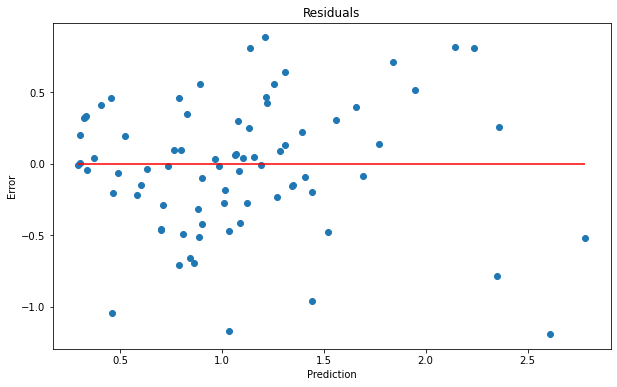

In [20]:
rf = RandomForestRegressor()
rf = evaluateModel(rf, xGS_X_train2, xGS_y_train2, xGS_X_test2, xGS_y_test2)

TRAINING SET
root mean squared error (RMSE): 0.14900447947594103
R-squared (R2 ): 0.9510690202074457
MAE 0.11031311688311694

Testing SET
root mean squared error (RMSE): 0.4597987603958264
R-squared (R2 ): 0.5798341782586094
MAE 0.3554184615384615


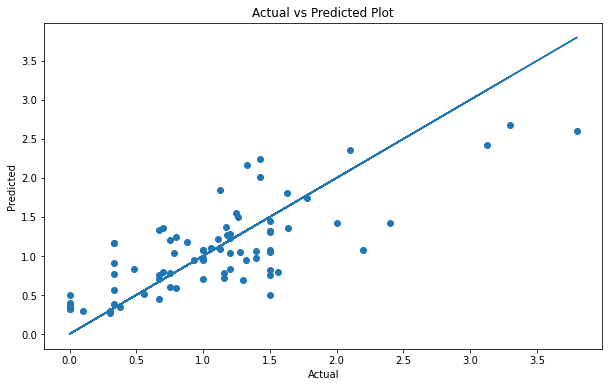

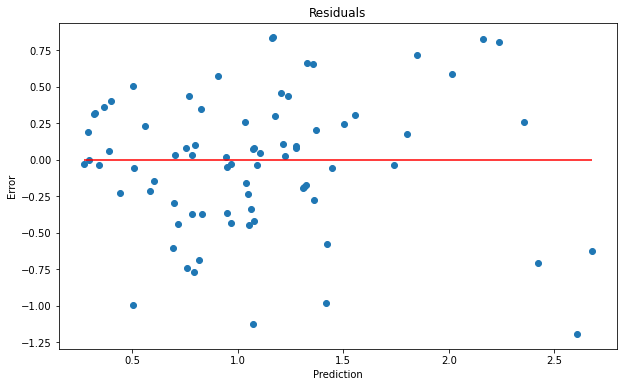

In [21]:
rf = RandomForestRegressor(n_estimators = 250)
rf = evaluateModel(rf, xGS_X_train2, xGS_y_train2, xGS_X_test2, xGS_y_test2)

In [ ]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

In [ ]:
# xGA Model 2 Exploration
lr = LinearRegression()
lr = evaluateModel(lr, xGA_X_train2, xGA_y_train2, xGA_X_test2, xGA_y_test2)

TRAINING SET
root mean squared error (RMSE): 0.22260945625054046
R-squared (R2 ): 0.9270038274338086
MAE 0.15870631205205074

Testing SET
root mean squared error (RMSE): 0.5749844498377992
R-squared (R2 ): 0.6155709516644442
MAE 0.41070195536695164


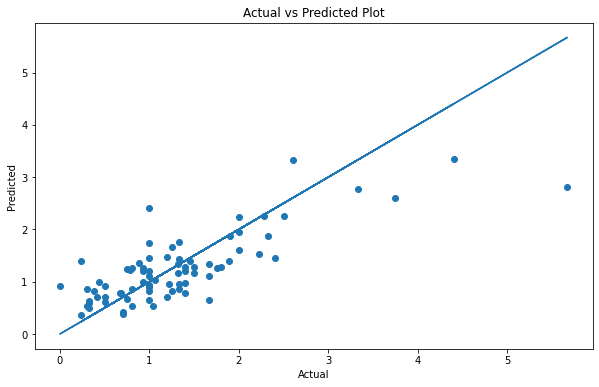

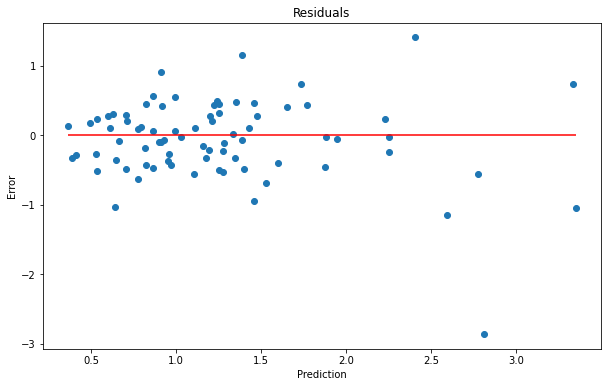

In [22]:
lgbm = LGBMRegressor(random_state=42)
lgbm = evaluateModel(lgbm, xGA_X_train2, xGA_y_train2, xGA_X_test2, xGA_y_test2)

In [ ]:
ridge = Ridge()
ridge = evaluateModel(ridge, xGA_X_train2, xGA_y_train2, xGA_X_test2, xGA_y_test2)

In [23]:
# Final Ridge Models
lasso_xGS =  ridge.fit(xGS_X2,xGS_y2)
lasso_xGA = ridge.fit(xGA_X2, xGA_y2)

In [ ]:
# xGS and xGA Preds using ridge regeression on second model

xGS_Preds = lasso_xGS.predict()
xGA_Preds = lasso_xGA.predict(xGA_y2)

In [ ]:
gb = GradientBoostingRegressor(random_state=42, n_estimators=400)
gb = evaluateModel(gb, xGA_X_train2, xGA_y_train2, xGA_X_test2, xGA_y_test2)

In [ ]:
rf = RandomForestRegressor(n_estimators = 400)
rf = evaluateModel(rf, xGA_X_train2, xGA_y_train2, xGA_X_test2, xGA_y_test2)

In [ ]:
gb = GradientBoostingRegressor(random_state=42, n_estimators=600, learning_rate=.05)
gb = evaluateModel(gb, xGA_X_train2, xGA_y_train2, xGA_X_test2, xGA_y_test2)

TRAINING SET
root mean squared error (RMSE): 0.4484823311074392
R-squared (R2 ): 0.7037191737545115
MAE 0.3307510099480464

Testing SET
root mean squared error (RMSE): 0.4393505003307347
R-squared (R2 ): 0.7755465692244159
MAE 0.3479750647978979


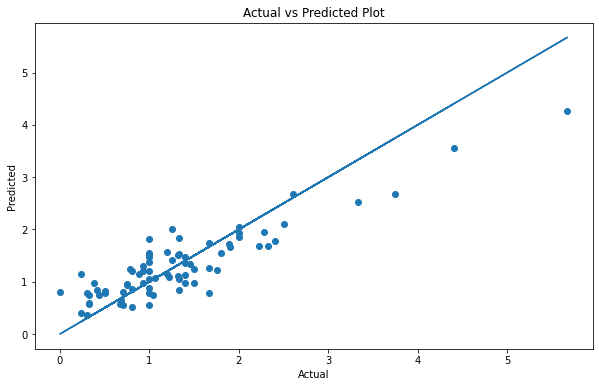

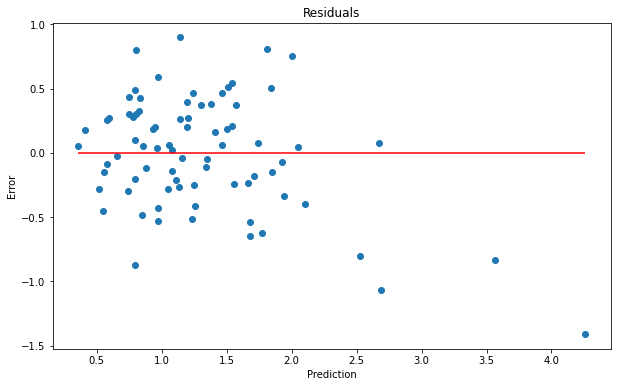

In [24]:
ridge = Ridge()
ridge = evaluateModel(ridge, xGA_X_train2, xGA_y_train2, xGA_X_test2, xGA_y_test2)